# ALMA ephemeris object imaging: continuum (mosaic gridder) with startmodel

## Description
The following demo describes continuum imaging of ALMA observation of Venus. For imaigng of the sources that move significantly during the observations, proper ephemeris data need to be used. For the current ALMA data, the epehemeris table used to track the source during the observation is generally included in the ASDM. The task, importasdm attaches the ephemeris table(s) in FIELD sub-table in the generated MS. Here we starts from such MS data and also uses a shortcut option called 'TRACKFIELD' in tclean to use the attached ephemeris table(s). The second tclean call is to test use of a starting model image.

## Data
The data is available at /home/casa/data/casatestdata.

## Installation
### Option 1

### Option 2

### Import libraries

In [1]:
from casatasks import getephemtable, tclean, exportfits, listobs, clearstat, imstat
from casatools import measures, quanta, table, image, msmetadata
import os
import aplpy
from astropy.io import fits
from matplotlib import pyplot
import pylab as pl
import shutil
me = measures()
qa = quanta()
tb = table()
ia = image()
msmd = msmetadata()

#### Import utility functions defined in a separate notebook

In [2]:
# import helper functions defined in EphemerisObjectImagingDemoFunctions.ipynb, which need to be
# present in the directory running the jupyter notebook/jupyter-lab

# requires ipynb 
from ipynb.fs.defs.EphemerisObjectImagingDemoFunctions import *

In order to track the ephemeris source during the observations, the proper ephemeris data is used. 
In the cases of recent ALMA or VLA data, such ephemeris data table(s) are attached to the Measurement Set automatically during importadm if they exists in the ASDM. There may be multiple tables per MS but only a single table is linked each field. These ephemeris tables are stored under FIELD subtable. The tables are used to calculate phases for gridding visibility. The ephemeis table is also used to stop the moving source. Setting phasecenter='TRACKFIELD' allows to use the same table for phase calculation and stopping of the moving source.

In [3]:
# Use the ALMA Venus data in casatestdata
datapath='/home/casa/data/casatestdata/measurementset/alma/'
# Use local data directory
#datapath='/Volumes/ssd1/casatestdata/measurementset/alma/'
#datapath='/Users/ttsutsum/SWDevel/ephemdemo/notebooks/'

In [4]:
# Copy the data to the local directory (not neccessary)
msfile='venus_ephem_test.ms'
if os.path.exists(msfile):
    shutil.rmtree(msfile)
os.system(f'cp -r {datapath}{msfile} {msfile}')

0

In [5]:
imgname='Venus-mosaic-mfs-trackfield'
img2name = 'Venus-mosaic-mfs-trackfield-startmodel'

In [6]:
# remove images from previous run
delete_tcleanimages(imgname)
delete_tcleanimages(img2name)

Run mosaic with usepointing = True to correctly account for shifting of the beam 

In [7]:
ret=tclean(vis=msfile, field='Venus', imagename=imgname, imsize=[480, 432], cell=['0.14arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100, cycleniter=50,fullsummary=True)
ret['iterdone']

100

Verify the startmodel is correctly used by comparing the 'modelFlux' values reported in the first tclean run and the 'startMOdelFlux' values from the second run.

In [8]:
print(ret['summaryminor'][0][0][0]['modelFlux'])

[-1.5851304531097412, -0.8094823360443115]


In [9]:
# use the model image from the first run as startmodel
ret2=tclean(vis=msfile, field='Venus', imagename=img2name, imsize=[480, 432], cell=['0.14arcsec'], 
           phasecenter='TRACKFIELD', specmode='mfs', gridder='mosaic', usepointing=True, niter=100, 
           cycleniter=50, startmodel='Venus-mosaic-mfs-trackfield.model',fullsummary=True)
ret2['iterdone']

100

In [10]:
print(ret2['summaryminor'][0][0][0]['startModelFlux'])

[-0.8094817399978638, -1.0156545639038086]


### Examination of the resultant image

Convert a CASA image to FITS image for displaying the image via aplpy

Get the direction of Venus at the first timestamp of the select data from the ephemeris table

In [11]:
# Find the path of the attached ephem. table for fieldid=0
ephemtab = get_attachedEphemtablepath(msfile,'Venus')
print(ephemtab)

venus_ephem_test.ms/FIELD/EPHEM0_Venus_58491.4.tab/


In [12]:
from casatasks import imhead
iminfo=imhead(img2name+'.image', mode='list')
iminfo['date-obs']

'2019/01/08/11:21:50.208000'

In [13]:

ineph_dir = ephem_dir(ephemtab, iminfo['date-obs'],'ALMA')
print(ineph_dir)
ineph_rad = qa.convert(ineph_dir['m0'],'deg')
ineph_decd = qa.convert(ineph_dir['m1'],'deg')
inephmarker = {'ineph':{'ra':ineph_rad['value'], 'dec':ineph_decd['value']}}

{'m0': {'unit': 'rad', 'value': -2.1053946095161686}, 'm1': {'unit': 'rad', 'value': -0.2960760011918846}, 'refer': 'ICRS', 'type': 'direction'}


INFO: Setting slices=[0, 0] [aplpy.core]


Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


INFO: Auto-setting vmin to -3.704e+00 [aplpy.core]
INFO: Auto-setting vmax to  3.598e+00 [aplpy.core]
ky=ineph
ineph at: 15:57:28.746, -016.57.50.059
image center: ('15:57:28.746', '-016.57.50.059')


<Figure size 1500x1500 with 0 Axes>

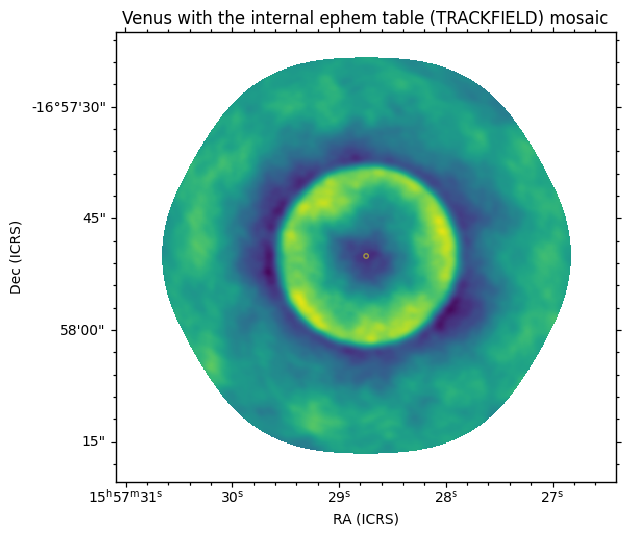

In [14]:
displayImage(img2name+'.image', markers=inephmarker, title='Venus with the internal ephem table (TRACKFIELD) mosaic')

Note: the marker in yellow is set to the direction based on the internal ephemeris table at the first time of the selected data. And it agrees with the coordinates of the center of the image.

In [15]:
print("internal ephem dir = ",qa.time(ineph_dir['m0'],prec=9),qa.angle(ineph_dir['m1'],prec=9))
printImageCenter(imgname+'.image')

internal ephem dir =  ['15:57:28.746'] ['-016.57.50.059']


('15:57:28.746', '-016.57.50.059')

In [16]:
stats = imstat(imgname+'.image')
print(f"{stats['max']}@{stats['maxpos']}")

[3.33001375]@[312 240   0   0]
